In [1]:
from os import listdir, chdir

In [147]:
import matplotlib.pyplot as plt


In [2]:
import sqlite3
import pandas as pd
import numpy as np

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

In [386]:
def retrieve(c,name):
    # ------ Getting from SQL DB ----- # 
    query = """SELECT * FROM {}""".format(name) + ";"
    c.execute(query)
    
    rows = c.fetchall()
    data = []
    for row in rows:
        data.append(row)

    # ----- Cleaning output ----- #
    columns = ['Date','Open','High','Low','Close','Adj_Close','Volume']
    data = pd.DataFrame(data, columns = columns)
    
    #clean data
    data['Date'] = pd.to_datetime(data['Date'])
    data['Volume'] = [int.from_bytes(value, byteorder = 'little') for value in data['Volume']]
    
    return data

In [5]:
chdir('./data')

In [6]:
conn = sqlite3.connect('ETF.db')

c = conn.cursor()

#### Get and Clean Data for 1 stock

In [7]:
a = retrieve(c,'AAAU')

In [12]:
columns = ['Date','Open','High','Low','Close','Adj_Close','Volume']
data = pd.DataFrame(a, columns = columns)
data.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2018-08-13,11.84,11.84,11.74,11.82,11.82,b'\xc4\xc0\x07\x00\x00\x00\x00\x00'
1,2018-08-20,11.88,12.08,11.85,12.05,12.05,b'\x08\xe9\x04\x00\x00\x00\x00\x00'
2,2018-08-27,12.06,12.13,11.97,12.00,12.00,b'\x94T\x12\x00\x00\x00\x00\x00'
3,2018-09-03,11.91,12.07,11.90,11.96,11.96,b'X\x83\x10\x00\x00\x00\x00\x00'
4,2018-09-10,11.97,12.12,11.88,11.93,11.93,b'\x8ch\x01\x00\x00\x00\x00\x00'


In [16]:
data['Date'] = pd.to_datetime(data['Date'])

In [19]:
#Convert byte values in Volume to int 
data['Volume'] = [int.from_bytes(value, byteorder = 'little') for value in data['Volume']]

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       105 non-null    datetime64[ns]
 1   Open       105 non-null    float64       
 2   High       105 non-null    float64       
 3   Low        105 non-null    float64       
 4   Close      105 non-null    float64       
 5   Adj_Close  105 non-null    float64       
 6   Volume     105 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 5.9 KB


Text(0, 0.5, 'Price')

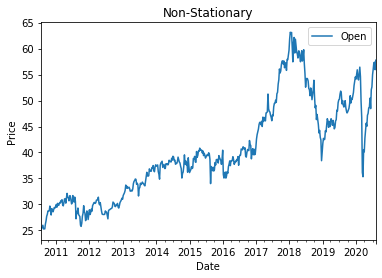

In [149]:
data.plot('Date','Open',kind = 'line')
plt.title('Non-Stationary')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

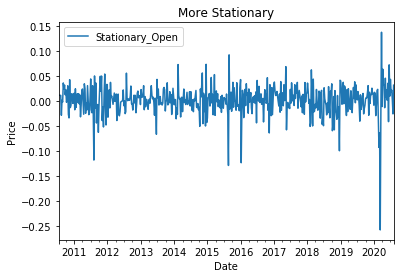

In [154]:
data['Stationary'] = np.log(data['Open']).diff(periods=1)[1:]
data.plot('Date','Stationary_Open',kind = 'line')
plt.title('More Stationary')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

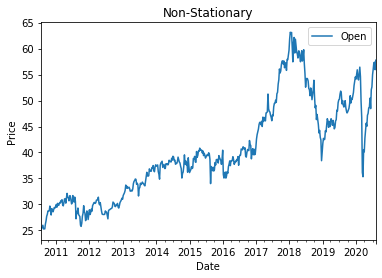

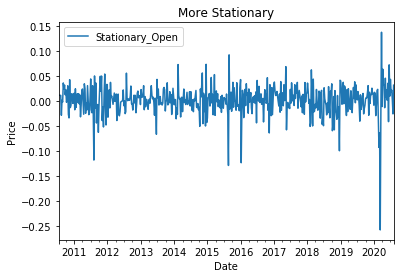

In [183]:
data.plot('Date','Open',kind = 'line')
plt.title('Non-Stationary')
plt.ylabel('Price')

data['Stationary_Open'] = np.log(data['Open']).diff(periods=1)[1:]
data.plot('Date','Stationary_Open',kind = 'line')
plt.title('More Stationary')
plt.ylabel('Price')

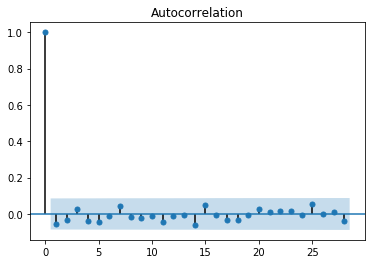

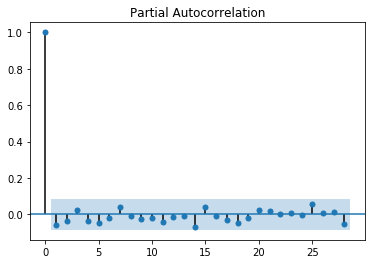

In [186]:
plot_acf(data['Stationary'][1:])
plot_pacf(data['Stationary'][1:])
print()

In [187]:
from statsmodels.tsa.arima_model import ARIMA

In [203]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(data['Open']), order = (1,1,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Open   No. Observations:                  525
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1116.970
Method:                       css-mle   S.D. of innovations              0.029
Date:                Sun, 06 Sep 2020   AIC                          -2225.940
Time:                        18:34:55   BIC                          -2208.887
Sample:                             1   HQIC                         -2219.262
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0014      0.000      7.739      0.000       0.001       0.002
ar.L1.D.Open     0.9599      0.013     74.365      0.000       0.935       0.985
ma.L1.D.Open    -1.0000      0.005   -194.089      0.000      -1.010      -0.990
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0418           +0.0000j            1.0418            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [213]:
forecast = model.forecast(10)
np.exp(forecast[0])

array([57.77318638, 57.79870571, 57.82646788, 57.85638661, 57.88837926,
       57.92236671, 57.95827314, 57.99602592, 58.03555545, 58.07679506])

In [205]:
a = data['Stationary'].copy()
a

0           NaN
1      0.011881
2      0.011742
3      0.011606
4     -0.028083
         ...   
521    0.018564
522    0.021901
523    0.002269
524   -0.025421
525    0.032022
Name: Stationary, Length: 526, dtype: float64

### FB Prophet model

In [216]:
from fbprophet import Prophet

In [243]:
prophet_data = data.loc[:, ['Date','Open']]

In [244]:
prophet_data['Open'] = np.log(prophet_data['Open'])

In [246]:
prophet_data['Open'] = prophet_data['Open'].diff(periods = 1)

In [247]:
prophet_data.rename(columns = {'Date': 'ds', 'Open': 'y'},inplace = True)
prophet_data.head()

,ds,y
0,2010-07-19,NaN
1,2010-07-26,0.011881
2,2010-08-02,0.011742
3,2010-08-09,0.011606
4,2010-08-16,-0.028083


In [249]:
prophet_data.head()

,ds,y
0,2010-07-19,NaN
1,2010-07-26,0.011881
2,2010-08-02,0.011742
3,2010-08-09,0.011606
4,2010-08-16,-0.028083


In [265]:
prophet_data.tail()

,ds,y
521,2020-07-13,0.018564
522,2020-07-20,0.021901
523,2020-07-27,0.002269
524,2020-08-03,-0.025421
525,2020-08-10,0.032022


In [327]:
m = Prophet()
m.fit(prophet_data[1:])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [328]:
future = m.make_future_dataframe(periods=40, freq = 'W')
future.tail()

,ds
560,2021-04-18
561,2021-04-25
562,2021-05-02
563,2021-05-09
564,2021-05-16


In [329]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
560,2021-04-18,0.005948,-0.029646,0.044185
561,2021-04-25,0.004498,-0.035192,0.039471
562,2021-05-02,0.002786,-0.035173,0.039781
563,2021-05-09,0.000521,-0.036360,0.036105
564,2021-05-16,-0.000830,-0.037273,0.034073


In [330]:
forecast['yhat'] = np.exp(forecast.loc[:,'yhat'])

In [332]:
forecast['yhat'].head()

0    1.002264
1    0.996371
2    0.994427
3    0.996023
4    0.999276
Name: yhat, dtype: float64

Make a series with the cumsum of forecasts and original starting datapoint

In [333]:
full = [data['Open'][0]]

In [334]:
full[1:] = forecast['yhat'].values
a = pd.Series(full)

In [337]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
560,2021-04-18,0.000991,-0.029646,0.044185,0.000991,0.000991,0.004957,0.004957,0.004957,0.004957,0.004957,0.004957,0.0,0.0,0.0,1.005966
561,2021-04-25,0.000989,-0.035192,0.039471,0.000989,0.000989,0.003509,0.003509,0.003509,0.003509,0.003509,0.003509,0.0,0.0,0.0,1.004508
562,2021-05-02,0.000987,-0.035173,0.039781,0.000987,0.000987,0.001799,0.001799,0.001799,0.001799,0.001799,0.001799,0.0,0.0,0.0,1.002789
563,2021-05-09,0.000985,-0.036360,0.036105,0.000985,0.000985,-0.000463,-0.000463,-0.000463,-0.000463,-0.000463,-0.000463,0.0,0.0,0.0,1.000521
564,2021-05-16,0.000982,-0.037273,0.034073,0.000982,0.000982,-0.001812,-0.001812,-0.001812,-0.001812,-0.001812,-0.001812,0.0,0.0,0.0,0.999170


### FB Propht with uncleaned data

In [347]:
m = Prophet()

In [348]:
df = data.loc[:,['Date','Open']]
df.rename(columns = {'Date': 'ds', 'Open': 'y'}, inplace = True)

In [349]:
df.head()

,ds,y
0,2010-07-19,25.100000
1,2010-07-26,25.400000
2,2010-08-02,25.700001
3,2010-08-09,26.000000
4,2010-08-16,25.280001


In [350]:
model = m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [354]:
df.tail()

,ds,y
521,2020-07-13,56.000000
522,2020-07-20,57.240002
523,2020-07-27,57.369999
524,2020-08-03,55.930000
525,2020-08-10,57.750000


In [353]:
future_frame = model.make_future_dataframe(periods=4, freq = 'W')
future_frame.tail(7)

,ds
523,2020-07-27
524,2020-08-03
525,2020-08-10
526,2020-08-16
527,2020-08-23
528,2020-08-30
529,2020-09-06


In [355]:
forecast = model.predict(future_frame)

In [356]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-07-19,27.330508,24.415312,32.484481,27.330508,27.330508,1.087996,1.087996,1.087996,1.087996,1.087996,1.087996,0.0,0.0,0.0,28.418504
1,2010-07-26,27.364715,24.151995,32.643601,27.364715,27.364715,1.110385,1.110385,1.110385,1.110385,1.110385,1.110385,0.0,0.0,0.0,28.475101
2,2010-08-02,27.398923,23.768632,32.385640,27.398923,27.398923,0.800697,0.800697,0.800697,0.800697,0.800697,0.800697,0.0,0.0,0.0,28.199620
3,2010-08-09,27.433131,23.425286,31.973835,27.433131,27.433131,0.263539,0.263539,0.263539,0.263539,0.263539,0.263539,0.0,0.0,0.0,27.696670
4,2010-08-16,27.467339,22.546529,31.195604,27.467339,27.467339,-0.301260,-0.301260,-0.301260,-0.301260,-0.301260,-0.301260,0.0,0.0,0.0,27.166078


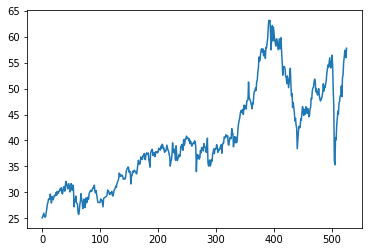

In [357]:
data['Open'].plot()

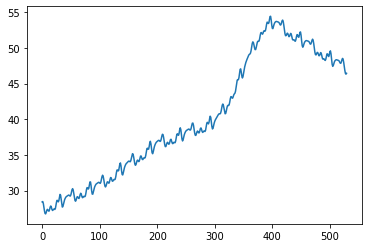

In [358]:
forecast['yhat'].plot()

In [360]:
data['Open'][10], forecast['yhat'][10]

(28.1, 27.308235876898404)

In [376]:
summary = pd.DataFrame()
summary['Original'] = data['Open'].values
summary['Forecast'] = forecast['yhat'].values[:-4]
summary.head()

,Original,Forecast
0,25.100000,28.418504
1,25.400000,28.475101
2,25.700001,28.199620
3,26.000000,27.696670
4,25.280001,27.166078


In [377]:
summary['Error'] = summary['Forecast'] - summary['Original']
summary['Error^2'] = summary['Error']**2

In [379]:
RMSE = np.sqrt(sum(summary['Error^2']/len(summary)))

In [380]:
RMSE

3.2677454070880048

In [396]:
def prophetize(data,p):
    m = Prophet() #initailize
    
    #format data
    df = data.loc[:,['Date','Open']]
    df.rename(columns = {'Date': 'ds', 'Open': 'y'}, inplace = True)
    
    #fit and forecast
    model = m.fit(df) 
    future_frame = model.make_future_dataframe(periods=p, freq = 'W')
    forecast = model.predict(future_frame)
    
    #Get summary stats
    summary = pd.DataFrame()
    summary['Original'] = data['Open'].values
    summary['Forecast'] = forecast['yhat'].values[:-4]
    
    summary['Error'] = summary['Forecast'] - summary['Original']
    summary['Error^2'] = summary['Error']**2
    
    RMSE = np.sqrt(sum(summary['Error^2']/len(summary)))
    
    return (RMSE, forecast, summary)

In [409]:
aaau = retrieve(c,'AAAU')
error, forecast, summary = prophetize(aaau,4)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [410]:
error

0.4463518012483258

In [413]:
forecast.loc[:,['ds','yhat']].tail()

,ds,yhat
104,2020-08-10,18.732418
105,2020-08-16,18.833419
106,2020-08-23,18.951253
107,2020-08-30,19.069087
108,2020-09-06,19.186921


### Using methods for model + predict ETFs

In [415]:
aaau = retrieve(c,'AAAU')
print(aaau.head())
error, forecast, summary = prophetize(aaau,4)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


        Date   Open   High    Low  Close  Adj_Close   Volume
0 2018-08-13  11.84  11.84  11.74  11.82      11.82   508100
1 2018-08-20  11.88  12.08  11.85  12.05      12.05   321800
2 2018-08-27  12.06  12.13  11.97  12.00      12.00  1201300
3 2018-09-03  11.91  12.07  11.90  11.96      11.96  1082200
4 2018-09-10  11.97  12.12  11.88  11.93      11.93    92300


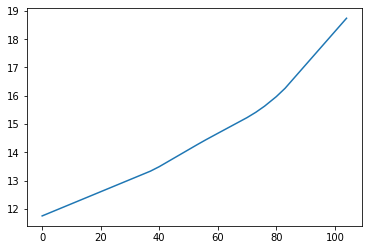

In [417]:
summary['Forecast'].plot()

In [398]:
aadr = retrieve(c,'AADR')
print(aadr.head())
error, forecast, summary = prophetize(aadr,4)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


        Date       Open       High        Low      Close  Adj_Close  Volume
0 2010-07-19  25.100000  25.540001  24.700001  25.280001  23.891865   68100
1 2010-07-26  25.400000  25.400000  24.990000  25.100000  23.721750   33800
2 2010-08-02  25.700001  25.910000  25.309999  25.709999  24.298254   19900
3 2010-08-09  26.000000  26.230000  25.040001  25.170000  23.787901    7200
4 2010-08-16  25.280001  25.900000  25.240000  25.299999  23.910763   11800


In [404]:
error

3.2677454070880048

In [403]:
forecast.loc[:,['ds','yhat']]

,ds,yhat
0,2010-07-19,28.418504
1,2010-07-26,28.475101
2,2010-08-02,28.199620
3,2010-08-09,27.696670
4,2010-08-16,27.166078
...,...,...
525,2020-08-10,47.387754
526,2020-08-16,46.869178
527,2020-08-23,46.442858
528,2020-08-30,46.310687
